In [1]:
import sys, math, random, heapq
import matplotlib.pyplot as plt
from itertools import chain

if sys.version_info < (3, 0):
   sys.exit("""Sorry, requires Python 3.x, not Python 2.x.""")

In [2]:
class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    # Lookup table for distances
    _d_lookup = {}

    def d(self, u, v):
        """Euclidean Metric d_2((x1, y1), (x2, y2))"""

        # Check if the distance was computed before
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]

        # Otherwise compute it
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)

        # Add to dictionary
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

    def plot(self, tour=None):
        """Plots the cities and superimposes given tour"""

        if tour is None:
            tour = Tour(self, [])

        _vertices = [self.vertices[0]]

        for i in tour.vertices:
            _vertices.append(self.vertices[i])

        _vertices.append(self.vertices[0])

        plt.title("Cost = " + str(tour.cost()))
        plt.plot(*zip(*_vertices), '-r')
        plt.scatter(*zip(*self.vertices), c="b", s=10, marker="s")
        plt.show()

In [3]:
class Tour:

    def __init__(self, g, vertices = None):
        """Generate random tour in given graph g"""

        self.g = g

        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices

        self.__cost = None

    def cost(self):
        """Return total edge-cost of tour"""

        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
        return self.__cost

In [ ]:
class GeneticAlgorithm:

    def __init__(self, g, population_size, iterations=1000, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        """Initialises algorithm parameters"""

        self.g = g

        self.population = []
        for _ in range(population_size):
            self.population.append(Tour(g))

        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        """Implements ordered crossover"""

        size = len(mum.vertices)

        # Choose random start/end position for crossover
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        # Replicate mum's sequence for alice, dad's sequence for bob
        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        # Fill the remaining position with the other parents' entries
        current_dad_position, current_mum_position = 0, 0

        for i in chain(range(start), range(end + 1, size)):

            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1

            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        # Return twins
        return Tour(self.g, alice), Tour(self.g, bob)

    def mutate(self, tour):
        """Randomly swaps pairs of cities in a given tour according to mutation rate"""

        # Decide whether to mutate
        if random.random() < self.mutation_rate:

            # For each vertex
            for i in range(len(tour.vertices)):

                # Randomly decide whether to swap
                if random.random() < self.mutation_swap_rate:

                    # Randomly choose other city position
                    j = random.randrange(len(tour.vertices))

                    # Swap
                    tour.vertices[i], tour.vertices[j] = tour.vertices[j], tour.vertices[i]

    def select_parent(self, k):
        """Implements k-tournament selection to choose parents"""
        tournament = random.sample(self.population, k)
        return max(tournament, key=lambda t: t.cost())

    def evolve(self):
        """Executes one iteration of the genetic algorithm to obtain a new generation"""

        new_population = []

        for _ in range(self.population_size):

            # K-tournament for parents
            mum, dad = self.select_parent(self.k), self.select_parent(self.k)
            alice, bob = self.crossover(mum, dad)

            # Mate in an  fashion according to the elitism_rate
            if random.random() < self.elite_mating_rate:
                if alice.cost() < mum.cost() or alice.cost() < dad.cost():
                    new_population.append(alice)
                if bob.cost() < mum.cost() or bob.cost() < dad.cost():
                    new_population.append(bob)

            else:
                self.mutate(alice)
                self.mutate(bob)
                new_population += [alice, bob]

        # Add new population to old
        self.population += new_population

        # Retain fittest
        self.population = heapq.nsmallest(self.population_size, self.population, key=lambda t: t.cost())


    def run(self, iterations=1000):
        for _ in range(iterations):
            if _ % 100 == 0:
                print(_)
            self.evolve()

    def best(self):
        return max(self.population, key=lambda t: t.cost())

In [9]:
g = Graph([(565.0, 575.0), (25.0, 185.0), (345.0, 750.0), (945.0, 685.0), 
           (845.0, 655.0), (880.0, 660.0), (25.0, 230.0), (525.0, 1000.0), 
           (580.0, 1175.0), (650.0, 1130.0), (1605.0, 620.0), (1220.0, 580.0), 
           (1465.0, 200.0), (1530.0, 5.0), (845.0, 680.0), (725.0, 370.0), 
           (145.0, 665.0), (415.0, 635.0), (510.0, 875.0), (560.0, 365.0), 
           (300.0, 465.0), (520.0, 585.0), (480.0, 415.0), (835.0, 625.0), 
           (975.0, 580.0), (1215.0, 245.0), (1320.0, 315.0), (1250.0, 400.0), 
           (660.0, 180.0), (410.0, 250.0), (420.0, 555.0), (575.0, 665.0), 
           (1150.0, 1160.0), (700.0, 580.0), (685.0, 595.0), (685.0, 610.0), 
           (770.0, 610.0), (795.0, 645.0), (720.0, 635.0), (760.0, 650.0), 
           (475.0, 960.0), (95.0, 260.0), (875.0, 920.0), (700.0, 500.0), 
           (555.0, 815.0), (830.0, 485.0), (1170.0, 65.0), (830.0, 610.0), 
           (605.0, 625.0), (595.0, 360.0), (1340.0, 725.0), (1740.0, 245.0)])

# Main

In [ ]:
N = 100

l_ga = []
for i in range(N):
    l_ga.append(GeneticAlgorithm(g, 100, iterations))
for ga in l_ga:
    ga.run()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


In [ ]:
best_tour = l_ga[0].best()

for i in range(N):
    tour = l_ga[i].best()
    if tour.cost() < best_tour.cost():
        best_tour = tour

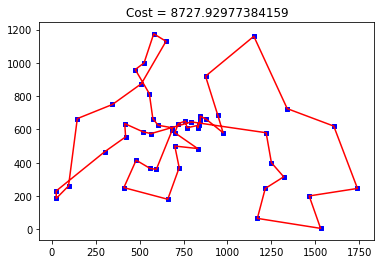

In [8]:
g.plot(best_tour)